## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tqdm.notebook import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/ML Project/Womens Clothing E-Commerce Reviews.csv')

## Data Preprocessing

In [4]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

Drop Some Features

In [5]:
df = df.drop(['Unnamed: 0', 'Clothing ID', 'Positive Feedback Count', 'Division Name'], axis=1)

Combine Recommended IND, Age, Department, Class, Title and Review

In [6]:
df['Combined Text'] = df.apply(lambda row: "{0} My age is {1} years.{2}{3}{4}{5}".format(
    "I recommend this item." if row['Recommended IND'] == 1 else "I don't recommend this item.",
    row["Age"],
    f" This item is from the {row['Department Name']} department." if not pd.isna(row['Department Name']) else "",
    f" It falls under the {row['Class Name']} class." if not pd.isna(row['Class Name']) else "",
    f" {row['Title']}." if not pd.isna(row['Title']) else "",
    f" {row['Review Text']}" if not pd.isna(row['Review Text']) else "",
), axis=1)

Lowercase

In [7]:
df['Combined Text'] = df['Combined Text'].str.lower()

In [8]:
df.shape

(23486, 8)

In [9]:
df.head(5)

,Age,Title,Review Text,Rating,Recommended IND,Department Name,Class Name,Combined Text
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimate,Intimates,i recommend this item. my age is 33 years. thi...
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses,Dresses,i recommend this item. my age is 34 years. thi...
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses,Dresses,i don't recommend this item. my age is 60 year...
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Bottoms,Pants,i recommend this item. my age is 50 years. thi...
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Tops,Blouses,i recommend this item. my age is 47 years. thi...


In [10]:
df['Rating'].value_counts(normalize = True)

5    0.559099
4    0.216171
3    0.122243
2    0.066635
1    0.035851
Name: Rating, dtype: float64

Train-Validation-Test Split

In [11]:
X = df['Combined Text'].values
y = pd.get_dummies(df['Rating']).values

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
  )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape

((16440,), (3523,), (3523,))

## Data Formatting

In [12]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Find Max Token Length

In [13]:
token_length = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length = max(token_length)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [14]:
X_train_tokens = tokenizer(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [15]:
X_val_tokens = tokenizer(
    X_val.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [16]:
X_test_tokens = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

## Model Architecture

1. Input Layer:
  * Shape: (max_token_length,)
  * Takes input ids and attention masks.

2. RoBERTa Layer:
  * Pre-Trained RoBERTa model for sequence classification.
  * Produces 'logits' as pooled output.

3. Output Layer:
  * Dense layer with Softmax activation function (5 units).

In [17]:
def create_model():
    input_ids = Input(shape=(max_token_length,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length,), dtype=tf.int32)

    roberta_model = TFAutoModelForSequenceClassification.from_pretrained('roberta-base')
    outputs = roberta_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(5, activation='softmax')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

Training Parameters (Recommended in BERT Paper published by Google):
* Optimizer: Adam
* Learning Rate: 2e-5
* Epochs: 10
* Batch Size: 32
* Early Stopping (Validation Loss with Patience = 3)

In [18]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 193)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 193)]                0         []                            
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['input_1[0][0]',             
 assification (TFRobertaFor  (loss=None, logits=(None,    70         'input_2[0][0]']             
 SequenceClassification)     2),                                                                  
                              hidden_states=None, atten                                       

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    [X_train_tokens['input_ids'], X_train_tokens['attention_mask']],
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_val_tokens['input_ids'], X_val_tokens['attention_mask']], y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
514/514 [==============================] - 758s 1s/step - loss: 1.0496 - accuracy: 0.6646 - val_loss: 0.8939 - val_accuracy: 0.6861
Epoch 2/10
514/514 [==============================] - 718s 1s/step - loss: 0.8422 - accuracy: 0.6979 - val_loss: 0.8075 - val_accuracy: 0.6974
Epoch 3/10
514/514 [==============================] - 719s 1s/step - loss: 0.7419 - accuracy: 0.7270 - val_loss: 0.7847 - val_accuracy: 0.7011
Epoch 4/10
514/514 [==============================] - 721s 1s/step - loss: 0.6741 - accuracy: 0.7502 - val_loss: 0.7913 - val_accuracy: 0.6932
Epoch 5/10
514/514 [==============================] - 722s 1s/step - loss: 0.6078 - accuracy: 0.7724 - val_loss: 0.8246 - val_accuracy: 0.6878
Epoch 6/10
514/514 [==============================] - 718s 1s/step - loss: 0.5535 - accuracy: 0.7950 - val_loss: 0.8482 - val_accuracy: 0.6895


In [ ]:
model.save_weights('/content/gdrive/MyDrive/ML Project/Weights/RoBERTa (Rating).h5')

# Evaluation

In [19]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.load_weights('/content/gdrive/MyDrive/ML Project/Weights/RoBERTa (Rating).h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 193)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 193)]                0         []                            
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['input_3[0][0]',             
 assification_1 (TFRobertaF  (loss=None, logits=(None,    70         'input_4[0][0]']             
 orSequenceClassification)   2),                                                                  
                              hidden_states=None, atten                                     

In [20]:
y_test = np.argmax(y_test, axis=1) + 1
y_pred = model.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask']])
y_pred_class = np.argmax(y_pred, axis=1) + 1

111/111 [==============================] - 3214s 29s/step


In [21]:
accuracy_score(y_test, y_pred_class)

0.7008231620777746

In [22]:
precision_score(y_test, y_pred_class, average='weighted')

0.6499893337402043

In [23]:
recall_score(y_test, y_pred_class, average='weighted')

0.7008231620777746

In [24]:
f1_score(y_test, y_pred_class, average='weighted')

0.6703267362702524

In [25]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       126
           2       0.07      0.02      0.03       235
           3       0.40      0.59      0.48       431
           4       0.58      0.50      0.54       761
           5       0.84      0.93      0.88      1970

    accuracy                           0.70      3523
   macro avg       0.38      0.41      0.39      3523
weighted avg       0.65      0.70      0.67      3523



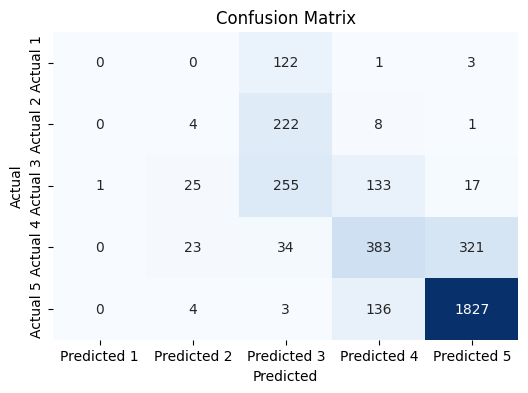

In [26]:
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()